In [1]:
from matplotlib.offsetbox import AnchoredText
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import _pickle as cPickle
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from datetime import datetime
import matplotlib.pyplot as plt
from driftutils import keep_in_domain as kid
from driftutils import utils
from plotutils import plotting_utils as putils
from scipy.interpolate import make_interp_spline
from matplotlib.pyplot import cm
from decimal import *
from collections import defaultdict

%matplotlib inline

## The plots in this notebook were used to explore the benefit of adding waves to experiments. They also attempt to address whether adding waves provides a benefit over and above the benefit gained by optimizing windage values

### Parameters
- The experiments mentioned in this notebook were created using the same input data as the drift-tool built-in wave example 
- CMEMS wave forcing (SMOC), CIOPS-E ocean model data, HRDPS winds, Spotter drifter 
- experiment time range is December 7-10, 2021 
- Drifters released every 6 hours with a duration of 48 hours 

### Jobsub scripts 
- /fs/vnas_Hdfo/dpnm/jeh326/dfo-drift-projection/drift-analysis/jen/general_dwt_tests/jobsub_scripts/stokes-sens_with-waves 
- /fs/vnas_Hdfo/dpnm/jeh326/dfo-drift-projection/drift-analysis/jen/general_dwt_tests/jobsub_scripts/stokes-sens 

In [7]:
lstyle_nums = ['solid', (0, (1, 1)), (0, (5, 5)), 'dashdot', (0, (1, 10)), 
               (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (1, 1)), (5, (10, 3)), 
               (0, (5, 1)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), 
               (0, (3, 10, 1, 10, 1, 10)), (0, (3, 1, 1, 1, 1, 1))] * 3


def save_pickle(filename, data):
    print('Creating ' + os.path.basename(filename))
    with open(filename, 'wb') as handle:
        cPickle.dump(data, handle)

        
def load_pickle(filename):
    print('Loading ' + os.path.basename(filename))
    with open(filename, 'rb') as handle:
        loaded_data = cPickle.load(handle)
    return loaded_data


def load_yaml_files(files):
    alldict = {}

    for yamlfile in files:
        with open(yamlfile, "rb") as input_file:
            bname = os.path.basename(yamlfile)
            for ch in ['.pickle','binned_skill_scores_all_wind_']:
                if ch in bname:
                    bname = bname.replace(ch, "")

            sname = bname.split('_')
            skill = [sname[1] if len(sname) == 2 else sname[2]][0]
            ident = bname.replace('_' + skill, '')
            yaml = cPickle.load(input_file)
            yaml_keys = yaml.keys()
            all_mean_df = yaml['all_mean'][['hours since start', skill]]
            all_mean_df = all_mean_df.rename(columns={'hours since start': 'hours_since_start'})
            all_drifters_df = yaml['all_drifters_all_tracks']

            if ident not in alldict.keys():
                alldict[ident] = {
                    #'filenames': [os.path.basename(yamlfile)],
                    #'bnames': [bname],
                    'wind': float(sname[0]),
                    'waves': [False if len(sname) == 2 else True][0],
                }
                alldict[ident][skill] = {
                    'all_mean': all_mean_df, 
                    #'min': np.nanmin(all_mean_df[skill]), 'max': np.nanmax(all_mean_df[skill]),
                    #'all_drifters_all_tracks': yaml['all_drifters_all_tracks'],
                }
            else:
                #alldict[ident]['filenames'].append(os.path.basename(yamlfile))
                #alldict[ident]['bnames'].append(bname)
                alldict[ident][skill] = {
                    'all_mean': all_mean_df,
                    #'min': np.nanmin(all_mean_df[skill]), 'max': np.nanmax(all_mean_df[skill]),
                    #'all_drifters_all_tracks': yaml['all_drifters_all_tracks'],
                }
    return alldict

def create_score_dataframe(alldict, skill, time):
    
    df_score = pd.DataFrame({'label': [], 'wind': [], 'skill': [], 'time': [], 'score': [], 'waves': []})
    for exp in alldict.keys():
        scoredf = alldict[exp][skill]['all_mean']
        score = list(scoredf.loc[scoredf['hours_since_start'] == float(time)].values)
        
        df_new = pd.DataFrame({'label': [exp], 'wind': [alldict[exp]['wind']], 
                               'skill': [skill], 'time': [time], 'score': [score[0][1]], 
                               'waves': [alldict[exp]['waves']]})
        df_score = pd.concat([df_score, df_new], ignore_index=True)
        df_score.reset_index()
        
        df_nowaves = df_score.loc[df_score['waves'] == 0]
        df_nowaves = df_nowaves.sort_values(by='wind', ascending=True)
        df_waves = df_score.loc[df_score['waves'] == 1]
        df_waves = df_waves.sort_values(by='wind', ascending=True)
    
    return df_score, df_waves, df_nowaves


def create_score_plot_dots(ax, df, bests, skill, hour):
    
    best_lab = (str(bests['waves']['wind']) + '_withwaves')
    labs = ['0.5_withwaves', '1_withwaves', '1.5_withwaves', '2_withwaves']
    all_wave_labels = list(df[df['waves'] == 1]['label'])
    lstyle_dict = {}
    for r in range(0, len(all_wave_labels)):
        lstyle_dict[all_wave_labels[r]] = lstyle_nums[r]
    
    for index, row in df.iterrows():
        ylab = str(skill)
        score = row.score
        if skill == 'sep':
            score = row.score / 1000
            ylab = str(skill) + ' [km]'
            
        if 'withwaves' in row.label:
            # plot horizonal lines for the with waves values
            if row.label in labs:
                lstyle = lstyle_dict[row.label]
                col = 'blue'
                uselab = row.wind
            else:
                lstyle = lstyle_dict[row.label]
                col = 'gray'
                uselab = '_no_label_'
                #continue
            #ax.axhline(score, zorder=1, linestyle=lstyle, color=col, label=uselab)
            ax.plot(row.wind, score, 'o', color='blue', markersize=4, label='_no_label_', zorder=1)
        else:
            # plot the dots for the no waves values
            ax.plot(row.wind, score, 'o', color='black', markersize=4, label='_no_label_', zorder=1)

    # plot a black line between the points
    nowaves_df = df.loc[df['waves'] == 0].sort_values(by='wind', ascending=True)
    scs = nowaves_df['score'].values
    if skill == 'sep':
        scs = scs / 1000
    ax.plot(nowaves_df['wind'].values, scs, 'k-', linewidth=0.5, zorder=1, label='_no_label_')
    
    # plot a black line between the points
    waves_df = df.loc[df['waves'] == 1].sort_values(by='wind', ascending=True)
    scs_waves = waves_df['score'].values
    if skill == 'sep':
        scs_waves = scs_waves / 1000
    ax.plot(waves_df['wind'].values, scs_waves, 'b-', linewidth=0.5, zorder=1, label='_no_label_')
    
    # add labels
    ax.set_ylabel(ylab)
    ax.set_xlabel('Windage (%)')
    ax.set_title(f'Average ' + str(skill) + ' at ' + str(int(hour)) + 'h')
    ax.yaxis.grid(True)
    
    # plot a vertical line though the best windage value with no waves
    ax.axvline(bests['nowaves']['wind'], zorder=100, color='red', linewidth=1, 
               label=('no waves (' + str(bests['nowaves']['wind']) + ')'))
        
    # plot a vertical line though the best windage value with no waves
    ax.axvline(bests['waves']['wind'], zorder=100, color='magenta', linewidth=1, 
               label=('waves (' + str(bests['waves']['wind']) + ')'))
    return ax


def create_score_plot(ax, df, bests, skill, hour):
    best_lab = (str(bests['waves']['wind']) + '_withwaves')
    labs = ['0.5_withwaves', '1_withwaves', '1.5_withwaves', '2_withwaves']
    all_wave_labels = list(df[df['waves'] == 1]['label'])
    lstyle_dict = {}
    for r in range(0, len(all_wave_labels)):
        lstyle_dict[all_wave_labels[r]] = lstyle_nums[r]
    
    for index, row in df.iterrows():
        ylab = str(skill)
        score = row.score
        if skill == 'sep':
            score = row.score / 1000
            ylab = str(skill) + ' [km]'
            
        if 'withwaves' in row.label:
            # plot horizonal lines for the with waves values
            if row.label in labs:
                lstyle = lstyle_dict[row.label]
                col = 'blue'
                uselab = row.wind
            else:
                continue
                #lstyle = lstyle_dict[row.label]
                #col = 'gray'
                #uselab = '_no_label_'
            ax.axhline(score, zorder=1, linestyle=lstyle, color=col, label=uselab)
        else:
            # plot the dots for the no waves values
            ax.plot(row.wind, score, 'o', color='black', markersize=4, label='_no_label_', zorder=1)

    # plot a black line between the points
    nowaves_df = df.loc[df['waves'] == 0].sort_values(by='wind', ascending=True)
    scs = nowaves_df['score'].values
    if skill == 'sep':
        scs = scs / 1000
    ax.plot(nowaves_df['wind'].values, scs, 'k-', linewidth=0.5, zorder=1, label='_no_label_')
    
    # add labels
    ax.set_ylabel(ylab)
    ax.set_xlabel('Windage (%)')
    ax.set_title(f'Average ' + str(skill) + ' at ' + str(int(hour)) + 'h')
    ax.xaxis.grid(True)
    
    # plot a vertical line though the best windage value with no waves
    ax.axvline(bests['nowaves']['wind'], zorder=100, color='red', linewidth=1, 
               label='best without waves')
               #label=('no waves (' + str(bests['nowaves']['wind']) + ')'))
    
    # plot a horizontal line at the best windage value with waves
    best_score = bests['waves']['score']
    if skill == 'sep':
        best_score = best_score / 1000
    best_text = 'best waves (' + str(bests['waves']['wind']) + ')'
    ax.axhline(best_score, zorder=100, color='magenta', label=best_text)   
    #ax.add_artist(AnchoredText(best_text, loc=2))  # 'lower right'))
    ha, la = ax.get_legend_handles_labels()
    ax.legend([ha[-1]], [la[-1]])

    return ax


def find_maxmins(df, skill):
    scores = df['score'].values
    if skill == 'sep':
        best_score = np.nanmin(scores)
    else:
        best_score = np.nanmax(scores)
    best_wind_df = df.loc[df['score'] == best_score]
    best_wind = best_wind_df['wind'].values[0]
    
    return best_score, best_wind, best_wind_df


def create_score_subplots(alldict, skills, times, projdir, statsdir, yamldir, dots=False):

    fsize = (6 * len(skills), 4 * len(times))   
    fig, axs = plt.subplots(len(times), len(skills), figsize=fsize)  # , sharex=True)
    extremes = {}
    
    for score, ax_rows in zip(skills, axs.T):
        extremes[score] = {'xextrs': [], 'yextrs': []} 
        for hour, ax in zip(times, ax_rows):
            df_score, df_withwaves, df_nowaves = create_score_dataframe(alldict, score, hour)
            best_score_withwaves, best_wind_withwaves, best_wind_df_withwaves = find_maxmins(df_withwaves, score)
            best_score_nowaves, best_wind_nowaves, best_wind_df_nowaves = find_maxmins(df_nowaves, score)
            bests = {'nowaves': {'score': best_score_nowaves, 'wind': best_wind_nowaves},
                     'waves': {'score': best_score_withwaves, 'wind': best_wind_withwaves}}

            if dots:
                savename = 'sens_dots.png'
                ax = create_score_plot_dots(ax, df_score, bests, score, hour)
            else:
                savename = 'sens.png'
                ax = create_score_plot(ax, df_score, bests, score, hour)

            extremes[score]['xextrs'].append(ax.get_xlim())
            extremes[score]['yextrs'].append(ax.get_ylim())
    
    for score, ax_rows in zip(skills, axs.T):
        for hour, ax in zip(times, ax_rows):
            xextrs = extremes[score]['xextrs']
            xlims = [np.nanmin([x[0] for x in xextrs]), np.nanmax([x[1] for x in xextrs])]
            ax.set_xlim(xlims)
            #yextrs = extremes[score]['yextrs']
            #ylims_data_x = np.nanmin([y[0] for y in yextrs]), np.nanmax([y[1] for y in yextrs])]
            #ylims = [[0, 1] if score == 'molcard' else ylims_data]
            #ax.set_ylim(ylims)
            
    handles, labels = ax.get_legend_handles_labels()
    if not dots:
        fig.legend(handles[0:-1], labels[0:-1], title=('exps with waves'), loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(pad=5)
    #print('saving ' + str(os.path.join(projdir, savename)))
    plt.savefig(os.path.join(projdir, savename), dpi=600)
    
    
def examine_bests(alldict, times=None, skills=None):
    allbests = {}
    if not skills:
        skills = ['molcard', 'sep', 'liu']
    if not times:
        times = [hour for hour in range(1, 49, 1)]
    for score in skills:
        allbests[score] = {'nowaves': [], 'waves': []}
        for hour in times:
            df_score, df_withwaves, df_nowaves = create_score_dataframe(alldict, score, hour)
            best_score_waves, best_wind_waves, best_wind_df_waves = find_maxmins(df_withwaves, score)
            best_score_nowaves, best_wind_nowaves, best_wind_df_nowaves = find_maxmins(df_nowaves, score)
            bests = {'nowaves': {'score': best_score_nowaves, 'wind': best_wind_nowaves},
                     'waves': {'score': best_score_waves, 'wind': best_wind_waves}}
            allbests[score]['nowaves'].append((hour, best_wind_nowaves, best_score_nowaves))
            allbests[score]['waves'].append((hour, best_wind_waves, best_score_waves))
    return allbests


def add_smoothed_line(x, y, ax):
    x_y_spline = make_interp_spline(x, y)
    x_smooth = np.linspace(np.nanmin(x), np.nanmax(x), 500)
    y_smooth = x_y_spline(x_smooth)
    ax.plot(x_smooth, y_smooth, color='black', linewidth=0.1)
    

def add_bestdots_subplot(ax, skill, allbests, ftsize, msize, type, color=False):  #, col=None):
    
    skilldict = {'sep': 'Separation Distance', 'molcard': 'Molcard', 'liu': 'Liu'}
    
    if not color:
        #colordict = {'waves': 'blue', 'nowaves': 'orange'}
        colordict = {'sep': {'waves': 'blue', 'nowaves': 'orange'},
                     'molcard': {'waves': 'blue', 'nowaves': 'orange'},
                     'liu': {'waves': 'blue', 'nowaves': 'orange'}}
        markerdict = {'waves': 'o', 'nowaves': 'o'}
        lstyledict = {'waves': '-', 'nowaves': '-'}
    else:
        #colordict = {'waves': col, 'nowaves': col}
        colordict = {'sep': {'nowaves': 'darkblue', 'waves': 'blue'},
                     'molcard': {'nowaves': 'firebrick', 'waves': 'red'},
                     'liu': {'nowaves': 'darkgreen', 'waves': 'lightseagreen'}}
        markerdict = {'waves': 'o', 'nowaves': '*'}
        lstyledict = {'waves': '--', 'nowaves': '-'}
    
    times = [x[0] for x in allbests[skill][type]]
    winds = [x[1] for x in allbests[skill][type]]
    
    # add a smoothed line just because it looks nice
    add_smoothed_line(times, winds, ax)
    
    # add horizontal lines for average 'best' values
    lab = 'average value for ' + type + ' (' + str(round(np.nanmean(winds), 1)) + ')'
    ax.axhline(np.nanmean(winds), color=colordict[skill][type], label=lab, linestyle=lstyledict[type])
    
    # add the actual values
    ax.plot(times, winds, markerdict[type], markersize=msize, label=type, color=colordict[skill][type])
    ax.set_title(skilldict[skill], fontsize=ftsize)
    ax.set_xlabel('time [hours]', fontsize=ftsize)
    ax.set_ylabel('windage', fontsize=ftsize)
    ax.grid()
    ax.set_xlim([0, 49])
    ax.set_ylim([0, 3])
        
            
def plot_best_dots(allbests, projdir, skills, color=False):
    
    fig, axs = plt.subplots(1, len(skills), figsize=(6 * len(skills), 6))
    
    #if not colors:
    #    colors = [None] * len(skills)
    
    ftsize = 14
    for skill, ax in zip(skills, [axs[0], axs[1], axs[2]]):
        add_bestdots_subplot(ax, skill, allbests, ftsize, 4, 'waves', color=color)
        add_bestdots_subplot(ax, skill, allbests, ftsize, 4, 'nowaves', color=color)
        subhandles, sublabels = ax.get_legend_handles_labels()
        subl = [sublabels[0], sublabels[2]]
        subh = [subhandles[0], subhandles[2]]
        ax.legend(subh, subl)
    
    handles, labels = axs[1].get_legend_handles_labels()
    l = [labels[1], labels[3]]
    h = [handles[1], handles[3]]
    fig.legend(h, l, loc='upper center', ncol=5, fontsize=ftsize) #  , title='best values', title_fontsize=ftsize)
    fig.tight_layout(pad=6)
    
    #print('saving ' + str(os.path.join(projdir, 'bests.png')))
    plt.savefig(os.path.join(projdir, 'bests.png'), dpi=600)
    
    
def add_data_to_df(allbests, skill, type):
    df = pd.DataFrame()
    data = allbests[skill][type]
    print(data)
    datalen = len(data)
    df['hour'] = [x[0] for x in data]
    df['wind'] = [x[1] for x in data]
    df['score'] = [x[2] for x in data]
    df['waves'] = [type] * datalen 
    df['skill'] = [skill] * datalen 
    return df
    
def create_alldf(allbests):
    alldf = pd.DataFrame(columns=['hour', 'wind', 'score', 'waves', 'skill'])
    for skill in ['sep', 'molcard', 'liu']:
        for type in ['waves', 'nowaves']:
            df = add_data_to_df(allbests, skill, type)
            alldf = pd.concat([alldf, df], ignore_index=True)

    return alldf

        
def best_windage_at_hour(alldf, skill, hour):
    
    subdf = alldf[alldf['hour'] == hour]
    ssubdf =  subdf[subdf['skill'] == skill]

    best_windages = {'waves': ssubdf[ssubdf['waves'] == 'waves']['wind'].values[0],
                     'nowaves': ssubdf[ssubdf['waves'] == 'nowaves']['wind'].values[0]}
    
    exps = []
    for key, val in best_windages.items():
        if key == 'waves':
            k = '_withwaves'
        else:
            k = ''
        exps.append('wind_' + str(val) + str(k))
       
    best_windages['exps'] = exps
    
    return best_windages


def set_up_map_plot(ax):
    ax.add_feature(cfeature.LAND.with_scale('10m'),
                   facecolor="lightgrey",
                   edgecolor='black',
                   linewidth=0.2,
                   alpha=1.0,
                   zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),
                   edgecolor='black',
                   linewidth=0.1,
                   alpha=1.0,
                   zorder=1)
    ax.gridlines(crs=crs.PlateCarree(),
                 draw_labels=['bottom', 'left'],
                 xformatter=LongitudeFormatter(),
                 xlabel_style={'rotation': 45, 'ha': 'center'},
                 yformatter=LatitudeFormatter(),
                 ylabel_style={'rotation': 45, 'ha': 'center'},
                 linewidth=2, color='gray', alpha=0.1, 
                 linestyle='-', zorder=1)
    return ax


def find_avg_windage(df, by='hour', hours=None, skills=None):
    """average across all the windage values that give 
    the best skill score results. This can be done by 
    'hour', 'skill', or 'both'. """
 
    if hours:
        hours = [float(hour) for hour in hours]
        df = df[df['hour'].isin(hours)]
    if skills:
        df = df[df['skill'].isin(skills)]
    
    def get_rounded(x):
        return float(Decimal(str(x)).quantize(Decimal("1.0"),
                                           rounding=ROUND_HALF_UP))
    
    def get_grouped(df, by):
        if by == 'both':
            df = pd.DataFrame({'wind': [np.nanmean(df['wind'])]})
            keys = ['both']
        else:
            df = df[[by, 'wind']].groupby([by]).mean()
            keys = df.index.values
        winds = [get_rounded(w) for w in df['wind'].values]
        return dict(zip(keys, winds))
    
    avg_windages = {'waves': get_grouped(df[df['waves'] == 'waves'], by),
                    'nowaves': get_grouped(df[df['waves'] == 'nowaves'], by)}
      
    return avg_windages

    
def create_tracks_subplot(ax, ds, exps, skill=None, hour=None, lcolors=None):
    
    ax = set_up_map_plot(ax)
    expdict = putils.assign_colors(exps, lcolors)
    for exp in expdict.keys():
        data = ds.sel(setname=exp)
        for traj in range(0, len(data.mod_lon.values)):
            plab = exp.replace('wind', 'windage =').replace('_', ' ').replace('withwaves', '(waves included)')
            uselab = [exp if traj == 0 else '_no_label_'][0]
            obslab = ['obs' if traj == 0 else '_no_label_'][0]
            
            ax.plot(data.mod_lon.values[traj], data.mod_lat.values[traj], 
                    '-', transform=crs.PlateCarree(), zorder=10, label=uselab, 
                    color=expdict[exp], alpha=0.8, linewidth=0.5)
            
            ax.plot(data.mod_lon.values[traj][-1], data.mod_lat.values[traj][-1],
                    'o', transform=crs.PlateCarree(), zorder=100, label='_no_label_', 
                    markersize=4, color=expdict[exp])
            
            ax.plot(data.mod_lon.values[traj][0], data.mod_lat.values[traj][0],
                    'o', transform=crs.PlateCarree(), zorder=100, label='_no_label_', 
                    markersize=4, color='green')
            
            ax.plot(data.obs_lon.values[traj], data.obs_lat.values[traj], 
                    '-', color='black', transform=crs.PlateCarree(), zorder=1, 
                    label='_no_label_', linewidth=0.5)
    
    ax.legend()
    if skill:
        skilldict = {'sep': 'Separation Distance', 'molcard': 'Molcard', 'liu': 'Liu'}
        ax.set_title('Best ' + skilldict[skill] + ' results at ' + str(hour) + 'h')
    
    return ax


def return_exps_dict(d):
    exps_list = []
    for exp_type in d.keys():
        labs = ['wind_{}_withwaves'.format(w) if exp_type == 'waves' 
                else 'wind_{}'.format(w) for w in list(d[exp_type].values())]
        exps_list.append(dict(zip(list(d[exp_type].keys()), labs)))
    
    def concat_dicts(exps_list):
        exps = defaultdict(list)
        for i in range(len(exps_list)):
            current = exps_list[i]
            for key, value in current.items():
                exps[key].append(value)
        return dict(exps)

    exps = concat_dicts(exps_list)
    
    return exps
    

def create_avg_tracks(ds, expdict, savedir):

    keys = list(expdict.keys())
    fsize = (6 * len(keys), 4)
    fig, axs = plt.subplots(nrows=1, ncols=len(keys), 
                            subplot_kw={'projection': crs.PlateCarree()}, 
                            figsize=fsize)
    
    def do_the_plotting(ax, k, expdict, ds):
        exps = expdict[k]
        lcolors = dict(zip(exps, ['red', 'blue']))
        create_tracks_subplot(ax, ds, exps, lcolors=lcolors)
        skilldict = {'sep': 'Separation Distance', 'molcard': 'Molcard', 'liu': 'Liu'}
        if k in skilldict:
            tstr = 'Best average windage values for {}'
            titlestr = tstr.format(skilldict[k])
        elif k == 'both':
            titlestr = 'Best average windage values'
        elif isinstance(k, (int, np.integer)):
            titlestr = 'Best average windage values at ' + str(k) + 'h'
        else:
            titlestr = ''
        ax.set_title(titlestr)
    
    if len(keys) == 1:
        k = keys[0]
        ax = axs
        do_the_plotting(ax, k, expdict, ds)
    else:
        for k, ax in zip(keys, axs.T):
            do_the_plotting(ax, k, expdict, ds)
    
    keystr = '-'.join([str(k) for k in keys])
    savename = 'drifter_tracks_average_' + keystr + '.png'
    savepath = os.path.join(projdir, savename)
    plt.savefig(savepath, dpi=600)


def plot_average_windage_tracks(ds, df, by, hours, skills, savedir):
    avg_windages = find_avg_windage(df, by=by, hours=hours, skills=skills)
    expdict = return_exps_dict(avg_windages)
    create_avg_tracks(ds, expdict, savedir)
    
    
def set_up_plot(skills, hours, map=True):
    fsize = (6 * len(skills), 4 * len(hours))
    if map:
        fig, axs = plt.subplots(nrows=len(hours), ncols=len(skills), 
                                subplot_kw={'projection': crs.PlateCarree()}, 
                                squeeze=False, figsize=fsize)
    else:
        fig, axs = plt.subplots(nrows=len(hours), ncols=len(skills), squeeze=False, figsize=fsize)
    plot_skills = []
    plot_hours = []
    for hour in hours:
        for skill in skills:
            plot_skills.append(skill)
            plot_hours.append(hour)
    return fig, axs.flatten(), plot_skills, plot_hours

def create_tracks_plot(ds, alldf, savedir, skills, hours):
    
    fig, axs, plot_skills, plot_hours = set_up_plot(skills, hours)
    
    for ax, skill, hour in zip(axs, plot_skills, plot_hours):
        exps = best_windage_at_hour(alldf, skill, hour)['exps']
        lcolors = dict(zip(exps, ['red', 'blue']))
        create_tracks_subplot(ax, ds, exps, skill=skill, hour=hour, lcolors=lcolors)
 
    hours_str = [str(hour) for hour in hours]
    savename = 'drifter_tracks_' + '-'.join(skills) + '_' + '-'.join(hours_str) + '.png'
    savepath = os.path.join(projdir, savename)
    plt.savefig(savepath, dpi=600)

In [8]:
projdir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/stokes_drift/input_data/SalishSea/jupyter_notebook_input/skills_notebook_data"
statsdir = os.path.join(projdir, 'summary_stats_tables/')
pickled_outdir = os.path.join(projdir, 'pickled_output_files')
savedir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/OPPVF2F_2023/output/plots_stokes_sensitivity_study/rerun_notebook/"

# The individual stats files from the drift tool analysis:
yamldir = os.path.join(projdir, 'pickled_data/')
files = [fi for fi in glob.glob(os.path.join(yamldir, '*.pickle'))]

# The drift-tool cropped comparison output file:
comparison_dir = os.path.join(projdir, 'cropped_data/')
comparison_file = os.path.join(comparison_dir, "SPOT1017D2021120609_comparison.nc")
comparison_data = xr.load_dataset(comparison_file)

    
def create_data(files, pickled_outdir, load=True, load_alldict=True, load_allbests=True, load_alldf=True):
    
    pfiles = {'alldict': os.path.join(pickled_outdir, 'alldict.pickle'),
              'allbests': os.path.join(pickled_outdir, 'allbests.pickle'),
              'alldf': os.path.join(pickled_outdir, 'alldf.pickle')}

    if load and os.path.exists(pfiles['alldict']) and load_alldict:
        alldict = load_pickle(pfiles['alldict'])
    else:
        alldict = load_yaml_files(files)
        save_pickle(pfiles['alldict'], alldict)
        
    if load and os.path.exists(pfiles['allbests']) and load_allbests:
        allbests = load_pickle(pfiles['allbests'])
    else:
        allbests = examine_bests(alldict)
        save_pickle(pfiles['allbests'], allbests)
        
    if load and os.path.exists(pfiles['alldf']) and load_alldf:
        alldf = load_pickle(pfiles['alldf'])
    else:
        alldf = create_alldf(allbests)
        save_pickle(pfiles['alldf'], alldf)
        
    return alldict, allbests, alldf
    

alldict, allbests, alldf = create_data(files, pickled_outdir)

Loading alldict.pickle
Loading allbests.pickle
Loading alldf.pickle


## The following two figures attempt to show which windage value gives the best skill score at a particular time.

- Each row of subplots represents a particular hour (ie, all measurements in top row of subplots were taken at 6h, second row at 24h, etc). 
- Each column represents a particular skill score type
- waves experiment = blue and no_waves experiment = black

#### This first plot only shows a couple of representative waves experiment outputs. The next plot is similar and includes a wider range of waves experiments

- no_waves experiments = black dots
- waves experiments = horizontal lines

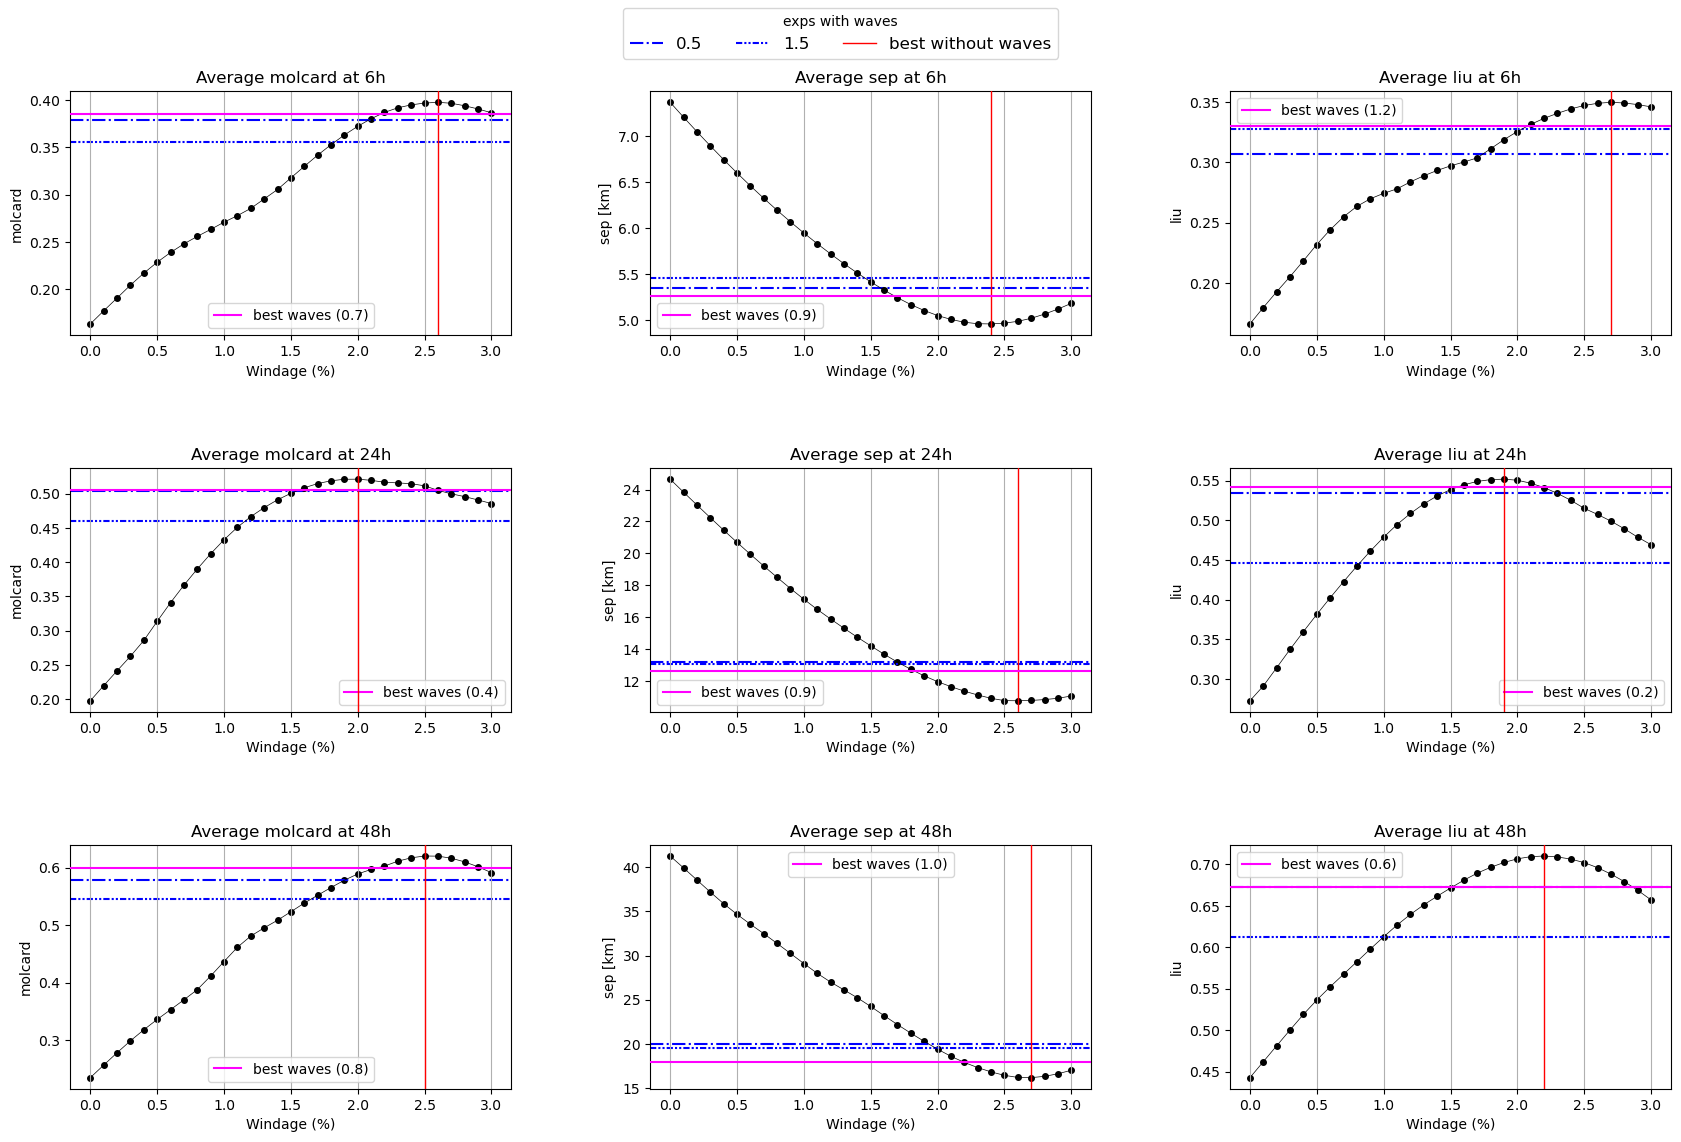

In [131]:
create_score_subplots(alldict, ['molcard', 'sep', 'liu'], ['6', '24', '48'], projdir, statsdir, yamldir, dots=False, savedir=savedir)

#### This plot shows the same information, but includes a wider range of with_wave experiment outputs
- The dots each represent the skillscore for a particular windage at that particular hour.
- The vertical lines represent the best skillscore obtained across all the different windages

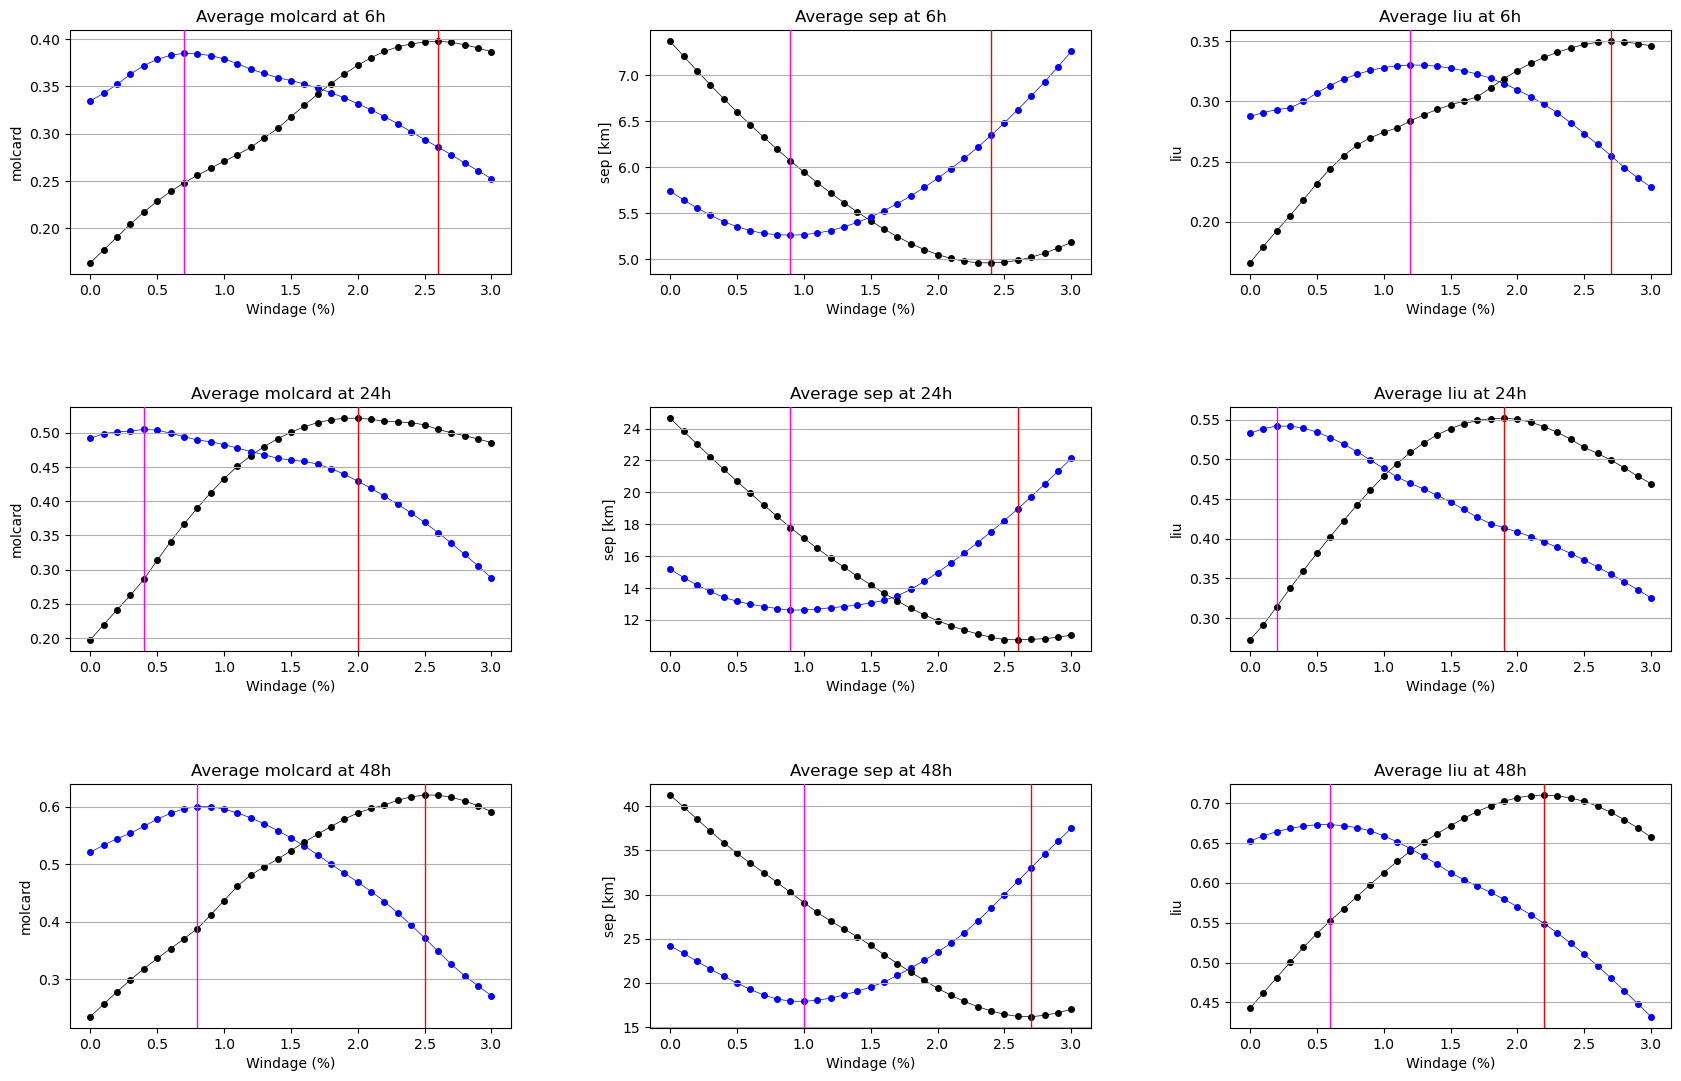

In [132]:
create_score_subplots(alldict, ['molcard', 'sep', 'liu'], ['6', '24', '48'], projdir, statsdir, yamldir, dots=True)

## The plot below attempts to explore how the 'best' windage value to use varies with time.

- Of all windages tested, which windage provides the 'best' skillscore value *at each hour*. 
- So, each dot shows which windage is giving the best skill score value *at that specific time*.
- For example, in the Molcard subplot: the windage that gives the best skill score at the 10 hour mark is ~2.1 and the windage that gives the best score at the 40 hour mark is ~2.5
- There are two sets of dots on each subplot, one for each of the waves (bottom, dotted lines) and no_waves experiments (top, solid lines). 
- The horizonal lines shows the average value of the windage across all the times.

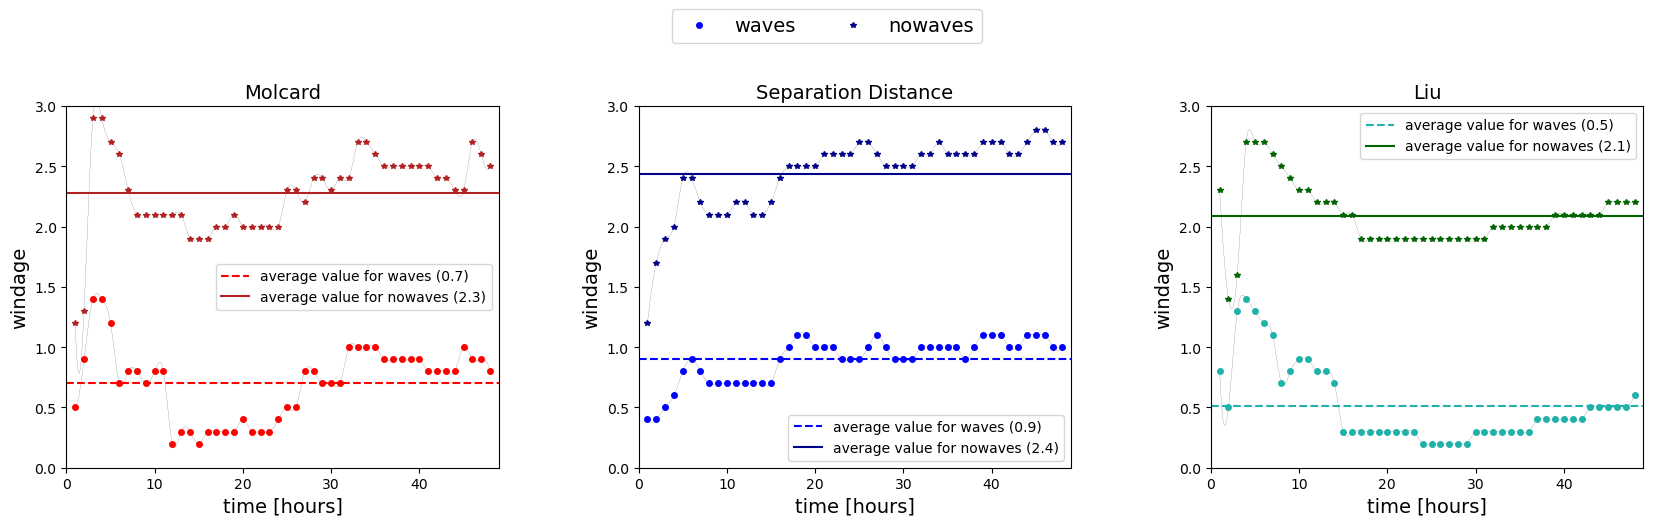

In [133]:
plot_best_dots(allbests, projdir, ['molcard', 'sep', 'liu'], color=True)

## The plot below tries to determine whether it would've been better to use output from the waves or no_waves experiment at each time

In [16]:
def create_score_diff_dataframe(alldf):
    waves = alldf[alldf['waves'] == 'waves']
    nowaves = alldf[alldf['waves'] == 'nowaves']
    cdf = pd.DataFrame({'hour': [], 'skill': [], 'score_waves': [], 'score_nowaves': []})
    for hour in np.unique(waves['hour'].values):
        waves_at_hour = waves[waves['hour'] == hour]
        nowaves_at_hour = nowaves[nowaves['hour'] == hour]
        for skill in waves_at_hour['skill']:
            wah_skill = waves_at_hour[waves_at_hour['skill'] == skill]
            nwah_skill = nowaves_at_hour[nowaves_at_hour['skill'] == skill]
            df_new = pd.DataFrame({'hour': [hour], 'skill': [skill], 
                                   'score_waves': wah_skill['score'].values, 
                                   'score_nowaves': nwah_skill['score'].values})
            cdf = pd.concat([cdf, df_new], ignore_index=True)
            cdf.reset_index()
    cdf['score_diff'] = cdf['score_nowaves'] - cdf['score_waves']
    
    combined_dict = {}
    combined_dict['cdf'] = cdf
    for skill in waves_at_hour['skill']:
        skill_df = cdf[cdf['skill'] == skill][['hour', 'score_waves', 
                                               'score_nowaves', 'score_diff']]
        skill_df = skill_df.reset_index()
        combined_dict[skill] = skill_df
    
    return combined_dict


def add_diffs_subplot(ax, df, skill, pind):
    
    params = {'sep': {'label': 'Separation Distance (km)', 'color': 'blue', 'altcolor': 'orange'}, 
              'molcard': {'label': 'Molcard', 'color': 'orange', 'altcolor': 'blue'}, 
              'liu': {'label': 'Liu', 'color': 'orange', 'altcolor': 'blue'}}

    if skill == 'sep':
        df['score_diff'] = df['score_diff'] / 1000
    times = df['hour'].values
    diffs = df['score_diff'].values
    
    ax.plot(times, diffs, linewidth=0.5, color='black')  # params[skill]['color'])
    
    colors = [params[skill]['color'] if d > 0 else params[skill]['altcolor'] for d in diffs]
    if skill == 'sep':
        nowaves_leg_str = 'higher skill when including waves'
        waves_leg_str = 'higher skill when not including waves'
    else:
        waves_leg_str = 'higher skill when including waves'
        nowaves_leg_str = 'higher skill when not including waves'
    leglabs = [nowaves_leg_str if d > 0 else waves_leg_str for d in diffs]
    if len(np.unique(colors)) == 1:
        leg_inds = [0]
    else:
        color_ind = np.where(colors[:-1] != colors[1:])[0] + 1
        leg_inds = [0, color_ind[0]]
    
    for time, diff, col, ind, leglab in zip(times, diffs, colors, range(0, len(diffs)), leglabs):
        lab = '_no_label_'
        if ind in leg_inds:
            lab = leglab
        ax.plot(time, diff, 'o', markersize=4, color=col, label=lab)
        
    ax.axhline(0, color='black')
    ax.set_xlabel('Time (hours)')
    if pind == 0:
        ax.set_ylabel('Skill Score Difference\n(score_nowaves - score_waves)')
    ax.set_title(params[skill]['label'])
    ax.grid(alpha=0.5)
    h, l = ax.get_legend_handles_labels()
    ax.legend(list(reversed(h)), list(reversed(l)))
    #ax.legend()
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    return ax


def plot_score_diffs(combined_dict, skills):
    
    fsize = (6 * len(skills), 5)
    fig, axs = plt.subplots(1, len(skills), figsize=fsize)
    for ind, ax, skill in zip(range(0, len(skills)), axs, skills):
        add_diffs_subplot(ax, combined_dict[skill], skill, ind)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout(pad=3)
    
    savename = 'score_diffs_' + '-'.join(skills) + '.png'
    savepath = os.path.join(projdir, savename)
    plt.savefig(savepath, dpi=600)

### The following plot shows:
- each dot shows what was used to obtain the highest skill score possible at each time. 
- The color shows which experiment gave the "best" skill score (waves = blue, no_waves = yellow)
- for example, in the first subplot, a better skill score was obtained when including waves at hour 1, but a better skill score was obtained without using waves at hour 2, etc
- The distance away from the horizontal line represents the amount that the "best" skill score values differed between the waves and no_waves experiments. When the value is close to zero, it's not significantly better to use the results from the waves experiment vs the no_waves experiment and vice versa. For example, in the second subplot, as time progresses a bigger improvement is seen in the results when using the no_waves experiment instead of by including waves.

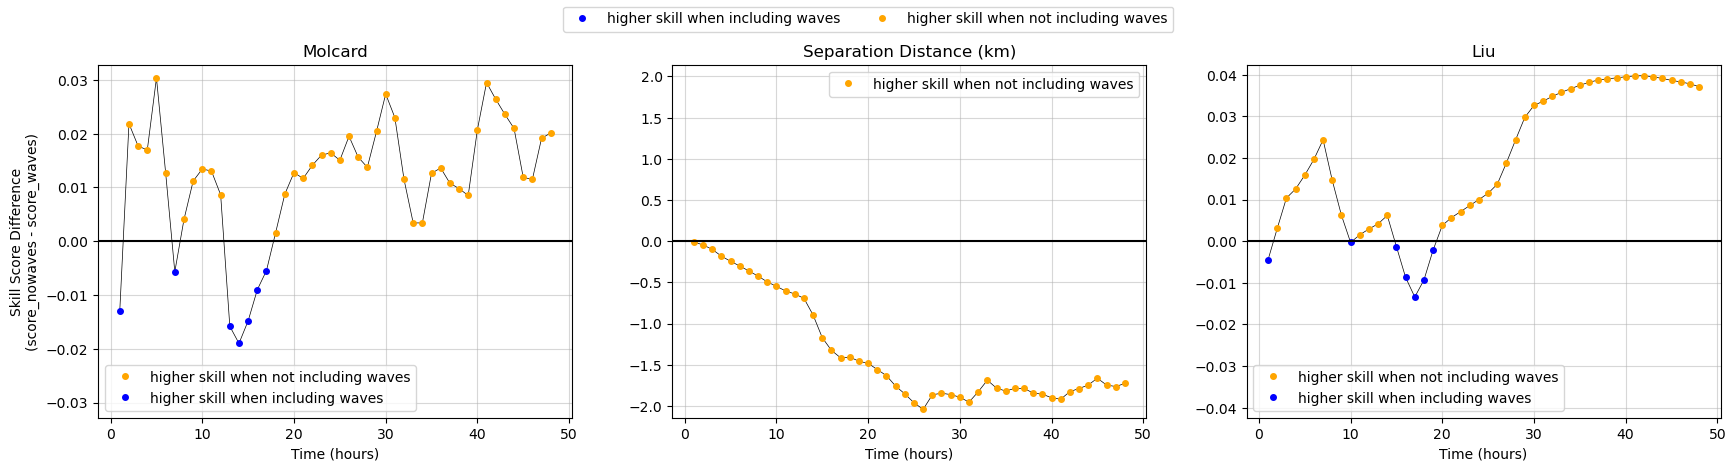

In [17]:
combined_dict = create_score_diff_dataframe(alldf)
cdf = combined_dict['cdf']
plot_score_diffs(combined_dict, ['molcard', 'sep', 'liu'])

### Finally, the following plots show the modelled tracks (one set for each of the waves and no_waves experiments). The experiment from which to plot the modelled tracks were determined in a number of different ways depending on the plot. 

### In this case, each row of subplots represents a specific hour and each column represents a skill score type

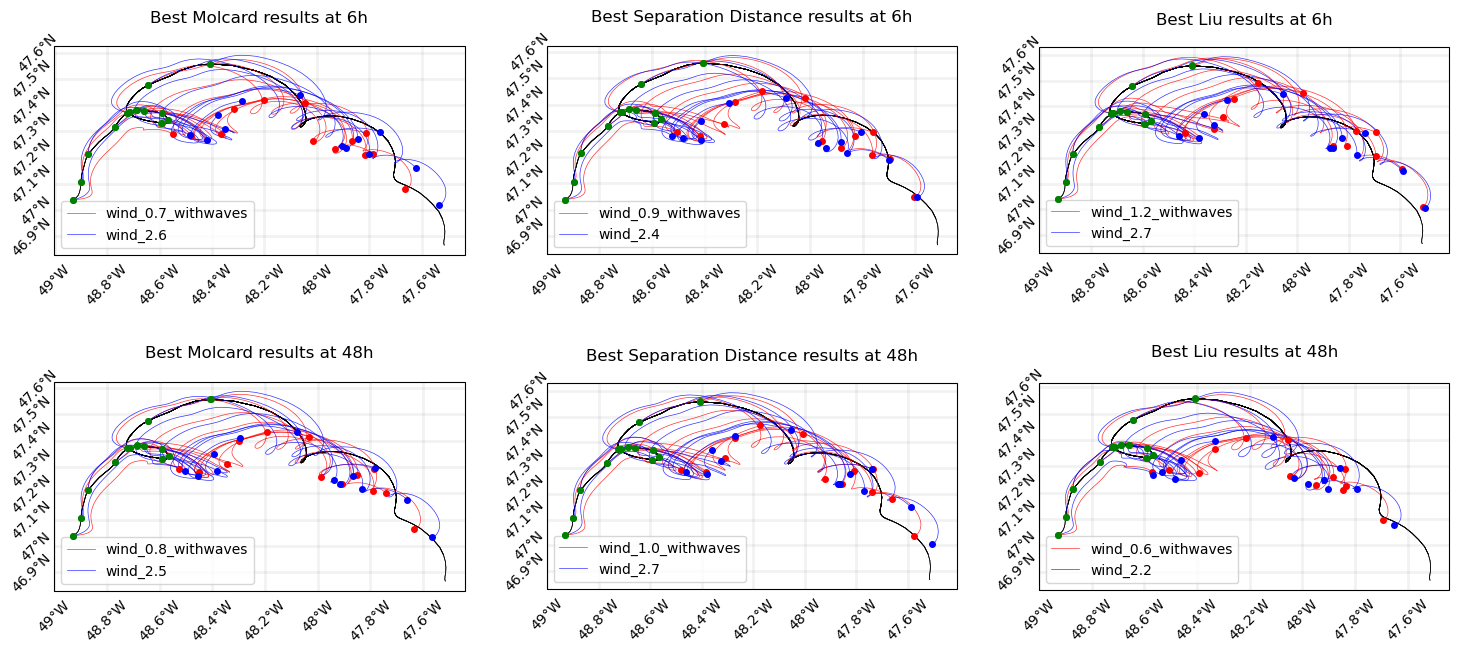

In [134]:
create_tracks_plot(comparison_data, alldf, projdir, ['molcard', 'sep', 'liu'], [6, 48])

### in this case, the best windage is averaged over all the different skill score types. So the first subplot represents the 'best' average windage value regardless of which skill score type gave the best results 

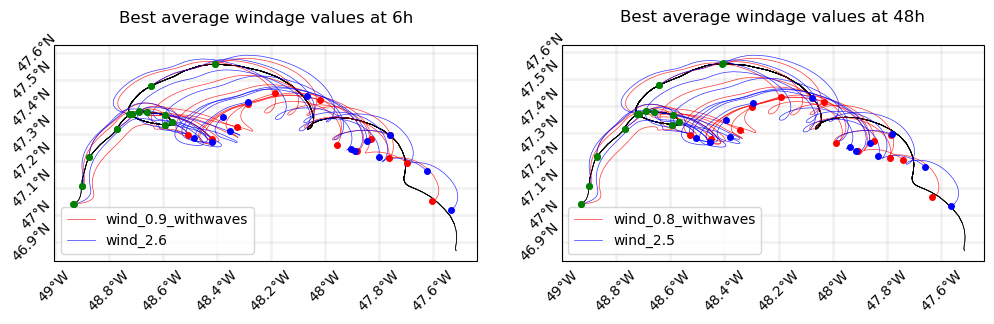

In [135]:
plot_average_windage_tracks(comparison_data, alldf, 'hour', [6, 48], ['molcard', 'sep', 'liu'], projdir)

### In this case, the 'best' windage values is averaged over all times and the results are plotted by skill score type. 

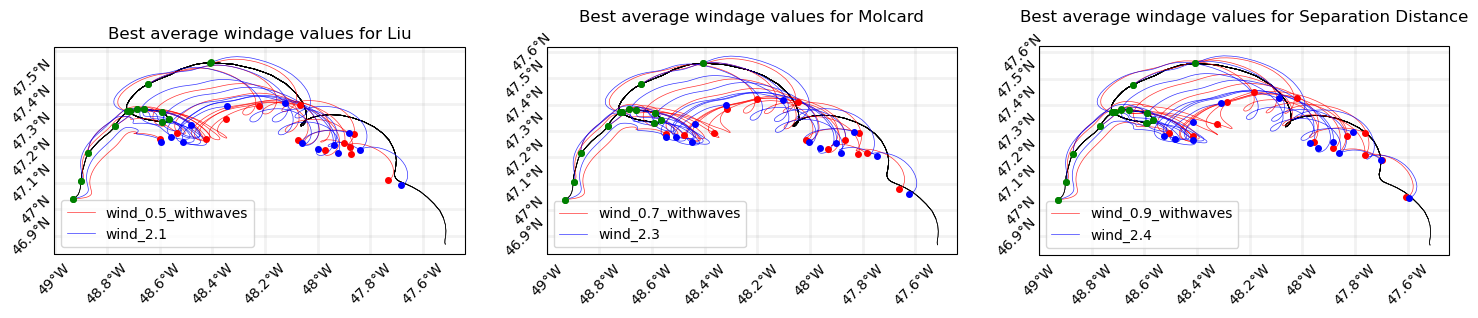

In [136]:
plot_average_windage_tracks(comparison_data, alldf, 'skill', 
                            [hour for hour in range(0, 49)], 
                            ['molcard', 'sep', 'liu'], projdir)

### In this plot, the windages were averaged across both times and skill scores. So, in this case, the plot shows the windage that gave the 'best' results regardless of the time and skill score

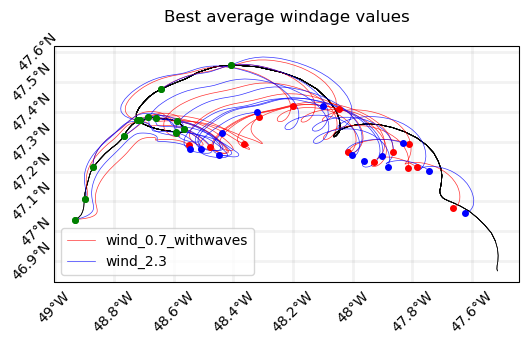

In [137]:
plot_average_windage_tracks(comparison_data, alldf, 'both', 
                            [hour for hour in range(0, 49)], 
                            ['molcard', 'sep', 'liu'], projdir)